In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from tslearn.preprocessing import TimeSeriesResampler

sns.set()

/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
SESSION_START_TIME_1 = datetime(1900, 1, 1, 11, 0, 0)
SESSION_START_TIME_2 = datetime(1900, 1, 1, 12, 0, 0)

SEED = 42

np.random.seed(SEED)

In [3]:
con = sqlite3.connect('data/trade_info.sqlite3')
trading_session = pd.read_sql('SELECT * FROM Trading_session', con)
chart_data = pd.read_sql('SELECT * FROM Chart_data', con)
con.close()

In [4]:
trading_session["date"] = pd.to_datetime(trading_session["date"], format="%Y-%m-%d")
trading_session = trading_session[trading_session.trading_type == "monthly"]

chart_data["time"] = pd.to_datetime(chart_data["time"], format="%H:%M:%S")
chart_data = chart_data[chart_data.time < datetime(1900, 1, 1, 17, 0, 0)]

In [5]:
chart_data.sort_values("time").drop_duplicates(subset="deal_id", inplace=True)

In [6]:
data = chart_data.join(trading_session.set_index("id"), on="session_id", how="inner")

In [7]:
data["datetime"] = data.apply(lambda x: datetime(x.date.year, x.date.month, x.date.day, x.time.hour, x.time.minute, x.time.second), axis=1)
data.sort_values("datetime", inplace=True)

data["hour"] = data["datetime"].apply(lambda x: int(x.hour))
data["minute"] = data["datetime"].apply(lambda x: int(x.minute))
data["second"] = data["datetime"].apply(lambda x: int(x.second))

In [8]:
data.drop(["date", "time", "trading_type", "deal_id", "id"], axis=1, inplace=True)

In [9]:
data["price_norm"] = data.groupby("session_id")["price"].transform(lambda x: x - x.mean())
data["lot_size_norm"] = data.groupby("session_id")["lot_size"].transform(lambda x: x - x.mean())

data["money"] = data.price * data.lot_size
data["money_"] = data.price_norm * data.lot_size

data["money_norm"] = data.groupby("session_id")["money"].transform(lambda x: x - x.mean())

In [10]:
data

,lot_size,session_id,price,platform_id,datetime,hour,minute,second,price_norm,lot_size_norm,money,money_,money_norm
1114,1,35,-0.735466,1,2019-02-21 11:05:02,11,5,2,0.000000,0.000000,-0.735466,0.000000,0.000000
1115,1,36,-1.129379,2,2019-02-21 11:05:02,11,5,2,0.000000,0.000000,-1.129379,0.000000,0.000000
968,16,39,-0.765767,1,2019-03-22 11:05:02,11,5,2,0.258807,-53.877660,-12.252270,4.140920,56.336497
969,4,39,-0.765767,1,2019-03-22 11:05:02,11,5,2,0.258807,-65.877660,-3.063068,1.035230,65.525700
927,16,39,-0.765767,1,2019-03-22 11:05:02,11,5,2,0.258807,-53.877660,-12.252270,4.140920,56.336497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,7,278,1.999198,2,2021-06-23 12:53:56,12,53,56,-0.041794,-24.310345,13.994386,-0.292561,-48.517603
5501,38,278,1.953746,2,2021-06-23 12:59:08,12,59,8,-0.087246,6.689655,74.242366,-3.315346,11.730378
5502,42,278,1.961322,2,2021-06-23 12:59:08,12,59,8,-0.079671,10.689655,82.375513,-3.346169,19.863524
5500,159,278,1.946171,2,2021-06-23 12:59:08,12,59,8,-0.094821,127.689655,309.441226,-15.076568,246.929238


# Clustering

In [11]:
feature = "price_norm"
n = 3
n_init = 10

In [12]:
ts = []

for session_id, values in data.groupby("session_id")[feature]:
    if values.shape[0] > 1:
        ts.append(values.tolist())
    
train = to_time_series_dataset(ts)

In [13]:
train = TimeSeriesResampler(sz=train.shape[1]).fit_transform(train)

# Euclidean

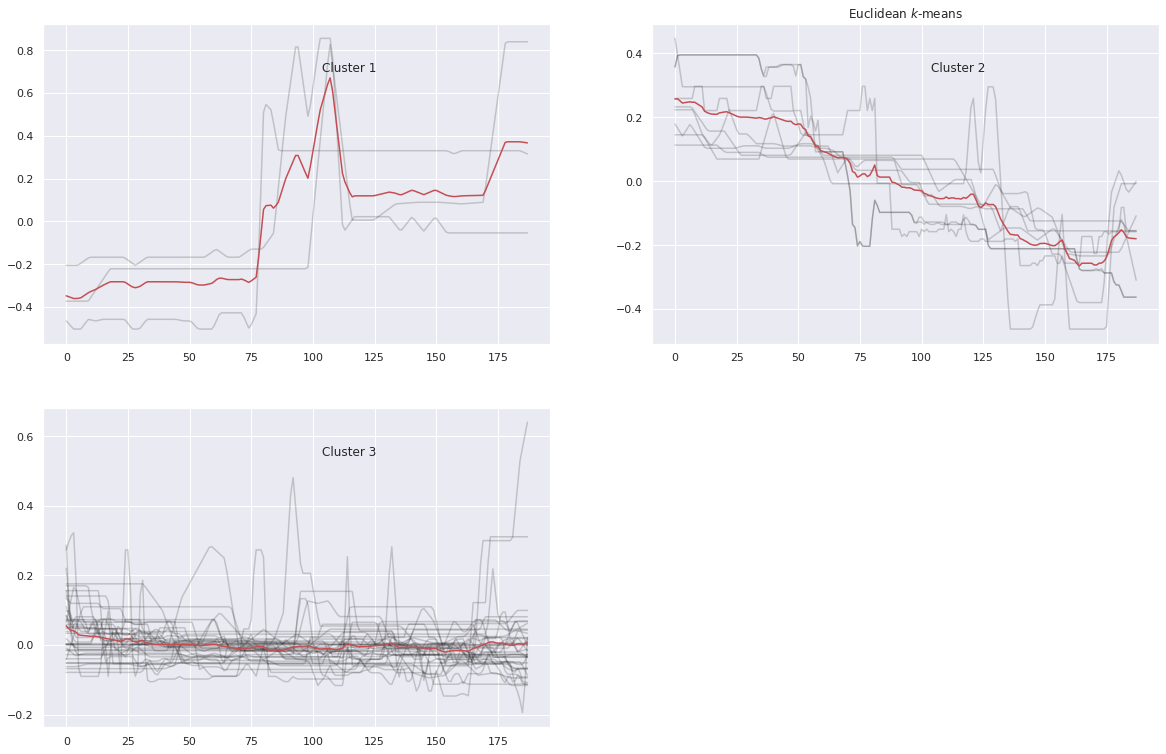

In [14]:
km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", random_state=SEED, n_init=n_init)
y_pred = km.fit_predict(train)

plt.figure(figsize=(20, 20))

for yi in range(n):
    plt.subplot(3, 2, 1 + yi)
    for xx in train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
        
plt.show()

# DTW

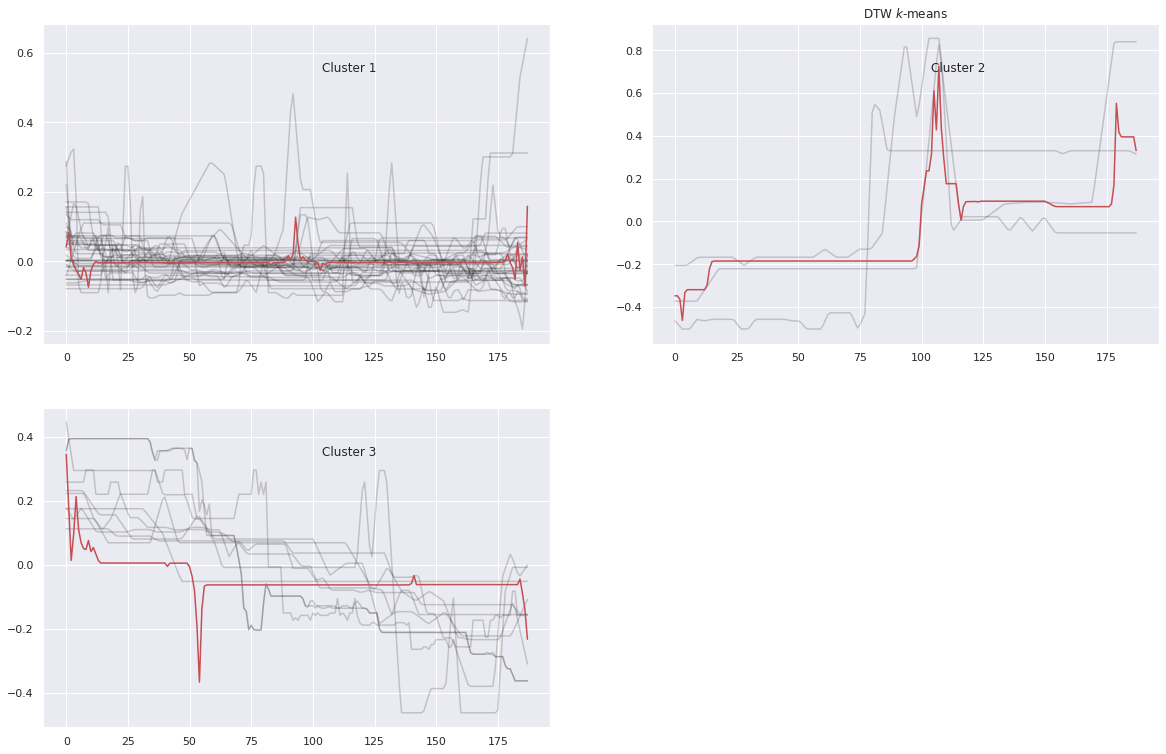

In [15]:
km = TimeSeriesKMeans(n_clusters=n, metric="dtw", random_state=SEED, n_init=n_init)
y_pred = km.fit_predict(train)

plt.figure(figsize=(20, 20))

for yi in range(n):
    plt.subplot(3, 2, 1 + yi)
    for xx in train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        
plt.show()

# Soft-DTW

In [16]:
km = TimeSeriesKMeans(n_clusters=n, metric="softdtw", random_state=SEED, n_init=n_init)
y_pred = km.fit_predict(train)

plt.figure(figsize=(20, 20))

for yi in range(n):
    plt.subplot(3, 2, 1 + yi)
    for xx in train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")
        
plt.show()

# KShape

In [ ]:
ks = KShape(n_clusters=n, verbose=True, random_state=SEED, n_init=n_init)
y_pred = ks.fit_predict(train)

plt.figure(figsize=(20, 20))
for yi in range(n):
    plt.subplot(3, 2, 1 + yi)
    for xx in train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

# Kernel KMeans

In [ ]:
gak_km = KernelKMeans(n_clusters=n,
                      kernel="cosine",
                    #   kernel_params={"sigma": "auto"},
                      n_init=n_init,
                      random_state=SEED)
y_pred = gak_km.fit_predict(train)

plt.figure(figsize=(20, 20))

for yi in range(n):
    plt.subplot(5, 2, 1 + yi)
    for xx in train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

Идея для тату

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.plot(data.datetime, data.price_norm)

plt.xlabel("Time")
plt.ylabel("Price")

plt.show()